# Week 9: Dropout

In [1]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw/train-images-idx3-ubyte.gz to /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw/train-labels-idx1-ubyte.gz to /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/hannahjordan/Documents/S22/adML/Week_9_Dropout/MNIST/raw



First, load in MNIST and display a character:

Image Size: (1, 28, 28)


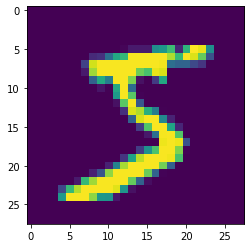

In [2]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1))

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [4]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [5]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [31]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [94]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [128,128,128] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [97]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 20
lr = 1e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [98]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/20, Iter: 100/480, Loss: 1.5340
Epoch: 1/20, Iter: 200/480, Loss: 1.5004
Epoch: 1/20, Iter: 300/480, Loss: 1.5986
Epoch: 1/20, Iter: 400/480, Loss: 1.5405
Epoch: 1/20, Iter: 480/480, Loss: 1.5527
Epoch 1 Train Accuracy: 92.80%
Epoch 1 Test Accuracy: 92.50%

Epoch: 2/20, Iter: 100/480, Loss: 1.5703
Epoch: 2/20, Iter: 200/480, Loss: 1.5513
Epoch: 2/20, Iter: 300/480, Loss: 1.5670
Epoch: 2/20, Iter: 400/480, Loss: 1.5159
Epoch: 2/20, Iter: 480/480, Loss: 1.4968
Epoch 2 Train Accuracy: 93.06%
Epoch 2 Test Accuracy: 92.73%

Epoch: 3/20, Iter: 100/480, Loss: 1.5533
Epoch: 3/20, Iter: 200/480, Loss: 1.5384
Epoch: 3/20, Iter: 300/480, Loss: 1.5306
Epoch: 3/20, Iter: 400/480, Loss: 1.5331
Epoch: 3/20, Iter: 480/480, Loss: 1.5207
Epoch 3 Train Accuracy: 93.59%
Epoch 3 Test Accuracy: 93.12%

Epoch: 4/20, Iter: 100/480, Loss: 1.5467
Epoch: 4/20, Iter: 200/480, Loss: 1.5348
Epoch: 4/20, Iter: 300/480, Loss: 1.5233
Epoch: 4/20, Iter: 400/480, Loss: 1.5207
Epoch: 4/20, Iter: 480/480, Loss: 1

In [99]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 95.17%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**

--> $2^n$

**TODO: How does dropout change the relationship of units in the network with their neighbors?**

--> It makes it so no one node can depend on it's neighbors, as at any point the node may be deactivated and no longer effect the results

In [100]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [101]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [128,128,128] # this should be an array with units per hidden layer
dropout_probs = [0.2,0.5,0.5,0.5]

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [102]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 50
lr2 = 1e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [103]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/50, Iter: 100/480, Loss: 2.2981
Epoch: 1/50, Iter: 200/480, Loss: 2.2244
Epoch: 1/50, Iter: 300/480, Loss: 2.0690
Epoch: 1/50, Iter: 400/480, Loss: 2.0674
Epoch: 1/50, Iter: 480/480, Loss: 1.9093
Epoch 1 Train Accuracy: 61.69%
Epoch 1 Test Accuracy: 62.22%

Epoch: 2/50, Iter: 100/480, Loss: 1.8630
Epoch: 2/50, Iter: 200/480, Loss: 1.8691
Epoch: 2/50, Iter: 300/480, Loss: 1.8609
Epoch: 2/50, Iter: 400/480, Loss: 1.7944
Epoch: 2/50, Iter: 480/480, Loss: 1.7606
Epoch 2 Train Accuracy: 75.23%
Epoch 2 Test Accuracy: 75.79%

Epoch: 3/50, Iter: 100/480, Loss: 1.8537
Epoch: 3/50, Iter: 200/480, Loss: 1.8410
Epoch: 3/50, Iter: 300/480, Loss: 1.7385
Epoch: 3/50, Iter: 400/480, Loss: 1.7607
Epoch: 3/50, Iter: 480/480, Loss: 1.7272
Epoch 3 Train Accuracy: 84.46%
Epoch 3 Test Accuracy: 84.68%

Epoch: 4/50, Iter: 100/480, Loss: 1.7090
Epoch: 4/50, Iter: 200/480, Loss: 1.7293
Epoch: 4/50, Iter: 300/480, Loss: 1.6721
Epoch: 4/50, Iter: 400/480, Loss: 1.7448
Epoch: 4/50, Iter: 480/480, Loss: 1

Epoch: 31/50, Iter: 200/480, Loss: 1.5265
Epoch: 31/50, Iter: 300/480, Loss: 1.5672
Epoch: 31/50, Iter: 400/480, Loss: 1.5437
Epoch: 31/50, Iter: 480/480, Loss: 1.5222
Epoch 31 Train Accuracy: 94.80%
Epoch 31 Test Accuracy: 94.48%

Epoch: 32/50, Iter: 100/480, Loss: 1.5217
Epoch: 32/50, Iter: 200/480, Loss: 1.5379
Epoch: 32/50, Iter: 300/480, Loss: 1.5595
Epoch: 32/50, Iter: 400/480, Loss: 1.5213
Epoch: 32/50, Iter: 480/480, Loss: 1.5805
Epoch 32 Train Accuracy: 94.84%
Epoch 32 Test Accuracy: 94.54%

Epoch: 33/50, Iter: 100/480, Loss: 1.5237
Epoch: 33/50, Iter: 200/480, Loss: 1.5561
Epoch: 33/50, Iter: 300/480, Loss: 1.5335
Epoch: 33/50, Iter: 400/480, Loss: 1.5354
Epoch: 33/50, Iter: 480/480, Loss: 1.5166
Epoch 33 Train Accuracy: 95.01%
Epoch 33 Test Accuracy: 94.69%

Epoch: 34/50, Iter: 100/480, Loss: 1.5450
Epoch: 34/50, Iter: 200/480, Loss: 1.5146
Epoch: 34/50, Iter: 300/480, Loss: 1.5677
Epoch: 34/50, Iter: 400/480, Loss: 1.5542
Epoch: 34/50, Iter: 480/480, Loss: 1.4909
Epoch 34 T

In [104]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 95.63%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**

--> The training takes longer to reach equilibrium on the dropout model. This is because we are removing nodes from the layers as we are training, meaning that we need longer to reach the weights. 

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [105]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    plt.tight_layout()
    plt.show()

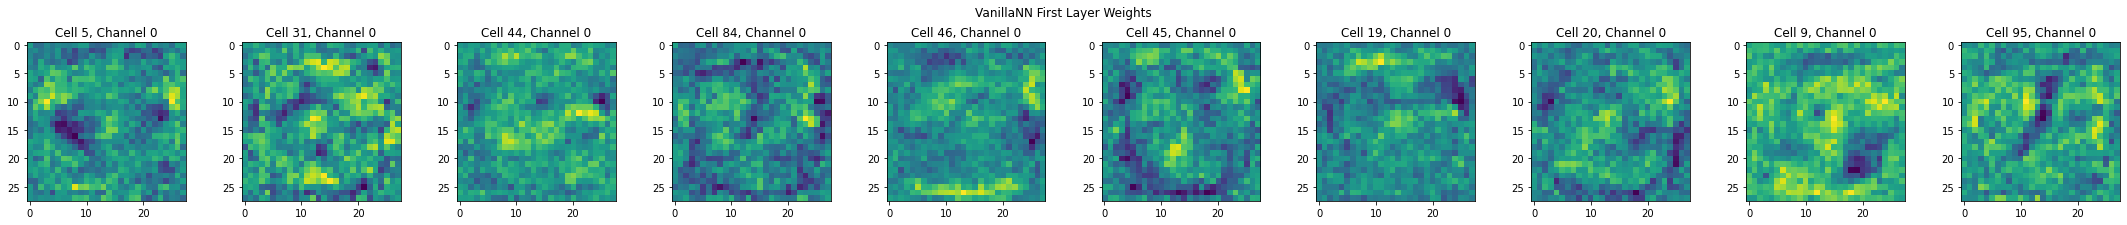

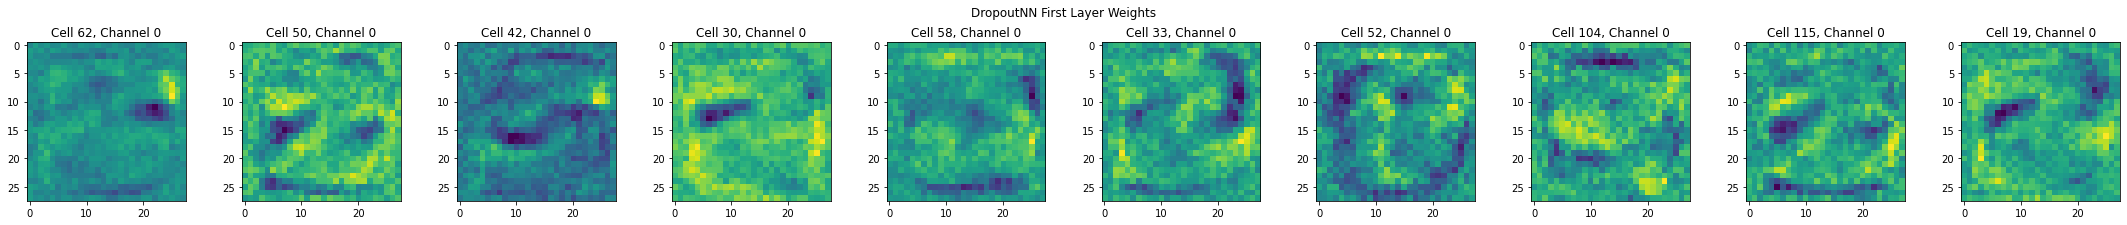

In [106]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)


Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**

--> There are not super obvious differences between the model weights, but I'd say there are more obvious features for the dropout model and there is less blurring together. This is because the model is not depending as much on the nodes surrounding each other, so the features aren't 'blurring' together.

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [107]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

Working on image 1/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 2
Epoch: 0/4500, Loss: 21.07
Epoch: 500/4500, Loss: -30.74
Epoch: 1000/4500, Loss: -65.79
Epoch: 1500/4500, Loss: -93.24
Epoch: 2000/4500, Loss: -123.13
Epoch: 2500/4500, Loss: -140.46
Epoch: 3000/4500, Loss: -147.29
Epoch: 3500/4500, Loss: -150.39
Epoch: 4000/4500, Loss: -152.05
Epoch: 4499/4500, Loss: -153.02
Working on image 2/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 5
Epoch: 0/4500, Loss: 5.89
Epoch: 500/4500, Loss: -25.52
Epoch: 1000/4500, Loss: -41.39
Epoch: 1500/4500, Loss: -53.38
Epoch: 2000/4500, Loss: -64.86
Epoch: 2500/4500, Loss: -74.38
Epoch: 3000/4500, Loss: -80.26
Epoch: 3500/4500, Loss: -82.83
Epoch: 4000/4500, Loss: -84.48
Epoch: 4499/4500, Loss: -85.12
Working on image 3/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 3
Epoch: 0/4500, Loss: 14.44
Epoch: 500/4500, Loss: -4

<IPython.core.display.Javascript object>


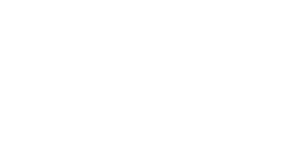

Working on image 1/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 1
Epoch: 0/4500, Loss: 0.70
Epoch: 500/4500, Loss: 0.55
Epoch: 1000/4500, Loss: -1.18
Epoch: 1500/4500, Loss: -1.80
Epoch: 2000/4500, Loss: -5.50
Epoch: 2500/4500, Loss: -14.01
Epoch: 3000/4500, Loss: -29.25
Epoch: 3500/4500, Loss: -50.11
Epoch: 4000/4500, Loss: -61.01
Epoch: 4499/4500, Loss: -67.15
Working on image 2/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 3
Epoch: 0/4500, Loss: 5.68
Epoch: 500/4500, Loss: -85.48
Epoch: 1000/4500, Loss: -147.43
Epoch: 1500/4500, Loss: -195.91
Epoch: 2000/4500, Loss: -229.61
Epoch: 2500/4500, Loss: -236.68
Epoch: 3000/4500, Loss: -239.38
Epoch: 3500/4500, Loss: -240.71
Epoch: 4000/4500, Loss: -241.69
Epoch: 4499/4500, Loss: -242.51
Working on image 3/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 7
Epoch: 0/4500, Loss: 20.21
Epoch: 500/4500, Loss: -30.15

<IPython.core.display.Javascript object>


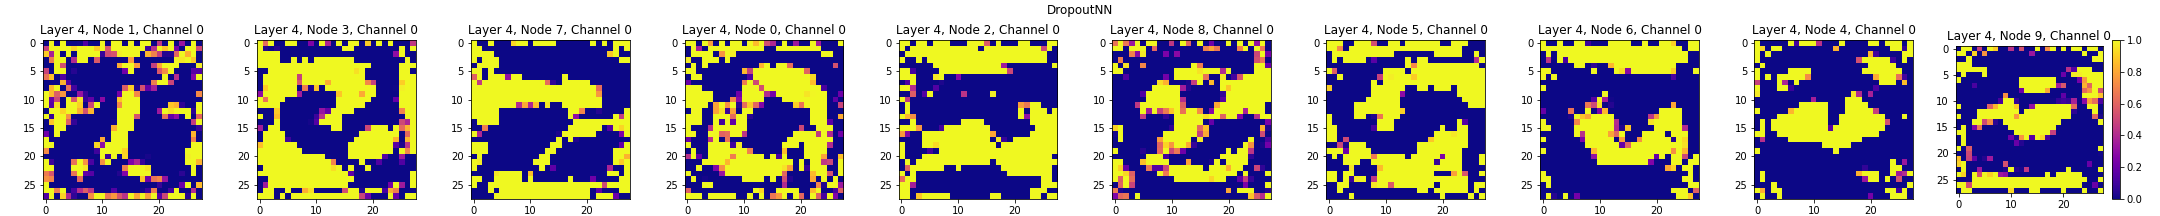

In [108]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


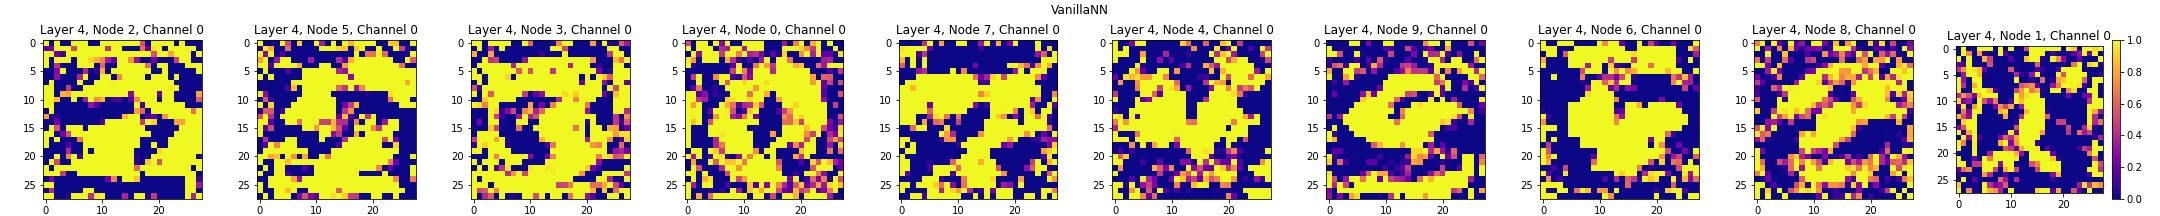

In [109]:
%matplotlib inline
vanilla_res

<IPython.core.display.Javascript object>


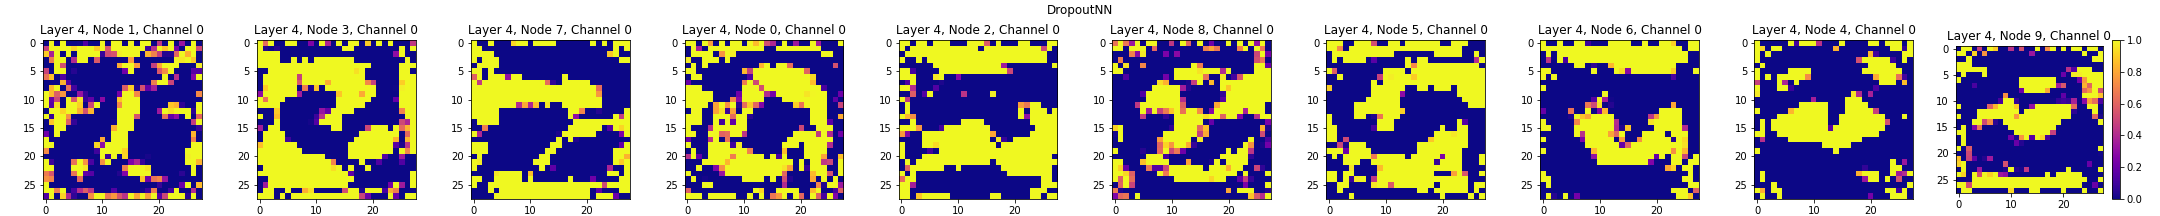

In [110]:
%matplotlib inline
dropout_res

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**

--> I'd say that there is less noise in the dropout net optimal images, which I think would be even more obvious if a little more tweaking was done to the model or if trained for longer. Again, the fact that you aren't allowing the nodes to become dependent on each other leads to the weights looking more distinct. To note: there is still quite a bit of saturation, this may be because of the noise of MNIST data.

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**

--> The dropout model is super saturated when looking at the first layer weights, while the vanilla nn looks almost the same as the last layer, just more saturated. While with the last layer, you can sort of make out different numbers, you can kind of make out a shape for the first layer of the vanilla net, but not for the dropout.

Working on image 1/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 27
Epoch: 0/4500, Loss: 1.62
Epoch: 500/4500, Loss: -1.25
Epoch: 1000/4500, Loss: -3.11
Epoch: 1500/4500, Loss: -4.66
Epoch: 2000/4500, Loss: -5.92
Epoch: 2500/4500, Loss: -6.75
Epoch: 3000/4500, Loss: -7.15
Epoch: 3500/4500, Loss: -7.37
Epoch: 4000/4500, Loss: -7.50
Epoch: 4499/4500, Loss: -7.58
Working on image 2/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 53
Epoch: 0/4500, Loss: 3.71
Epoch: 500/4500, Loss: -1.20
Epoch: 1000/4500, Loss: -3.07
Epoch: 1500/4500, Loss: -4.57
Epoch: 2000/4500, Loss: -5.79
Epoch: 2500/4500, Loss: -6.62
Epoch: 3000/4500, Loss: -7.07
Epoch: 3500/4500, Loss: -7.33
Epoch: 4000/4500, Loss: -7.49
Epoch: 4499/4500, Loss: -7.59
Working on image 3/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 70
Epoch: 0/4500, Loss: 3.76
Epoch: 500/4500, Loss: 2.89
Epoch: 1000/4500,

<IPython.core.display.Javascript object>


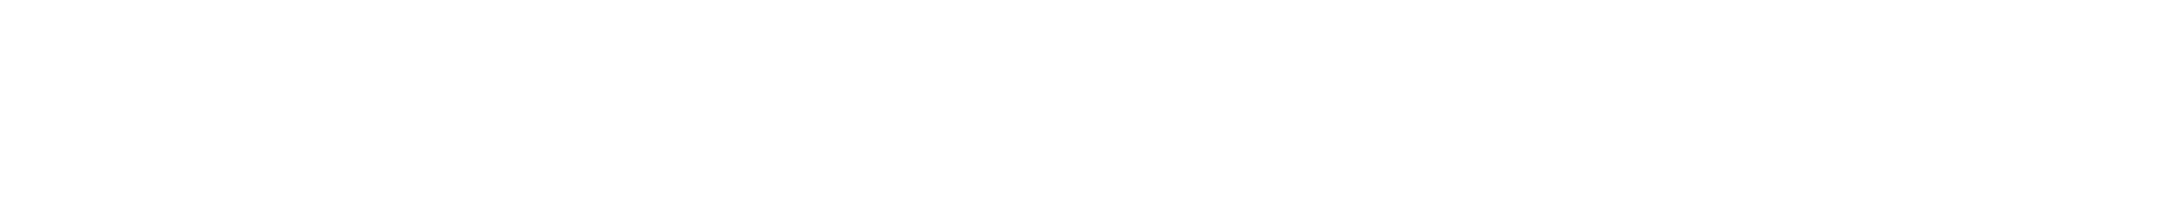

Working on image 1/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 101
Epoch: 0/4500, Loss: 2.70
Epoch: 500/4500, Loss: 0.02
Epoch: 1000/4500, Loss: 0.02
Epoch: 1500/4500, Loss: 0.02
Epoch: 2000/4500, Loss: 0.02
Epoch: 2500/4500, Loss: 0.02
Epoch: 3000/4500, Loss: 0.01
Epoch: 3500/4500, Loss: 0.01
Epoch: 4000/4500, Loss: 0.01
Epoch: 4499/4500, Loss: 0.00
Working on image 2/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 29
Epoch: 0/4500, Loss: 3.95
Epoch: 500/4500, Loss: 0.04
Epoch: 1000/4500, Loss: 0.01
Epoch: 1500/4500, Loss: 0.01
Epoch: 2000/4500, Loss: 0.01
Epoch: 2500/4500, Loss: 0.01
Epoch: 3000/4500, Loss: 0.01
Epoch: 3500/4500, Loss: 0.01
Epoch: 4000/4500, Loss: 0.00
Epoch: 4499/4500, Loss: -3.76
Working on image 3/10
Optimize Values After Layer Linear(in_features=784, out_features=128, bias=True), Node: 94
Epoch: 0/4500, Loss: 2.85
Epoch: 500/4500, Loss: 0.05
Epoch: 1000/4500, Loss: 0.02
Epoc

<IPython.core.display.Javascript object>


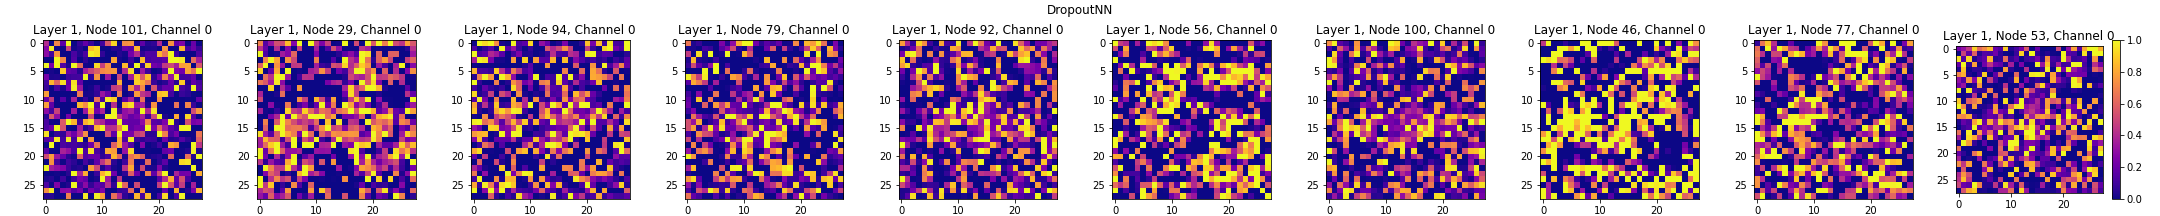

In [111]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 1, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 1, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


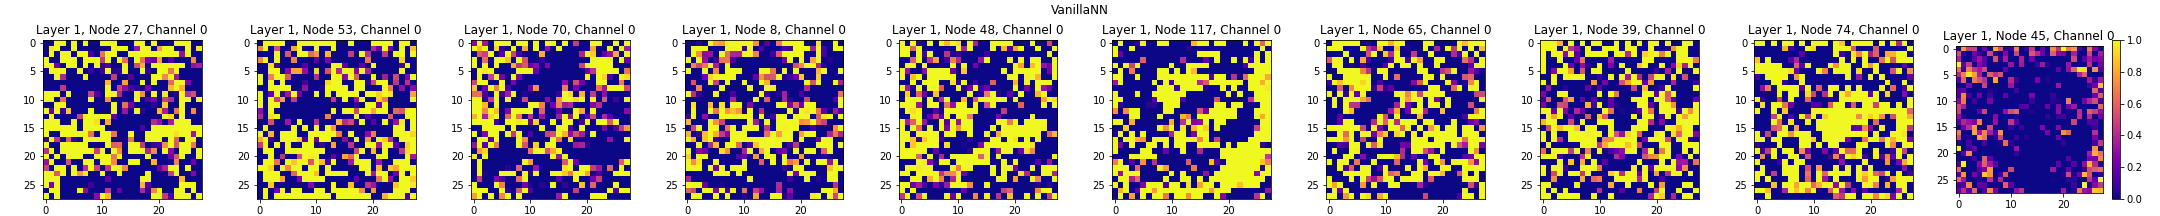

In [112]:
%matplotlib inline
vanilla_res

<IPython.core.display.Javascript object>


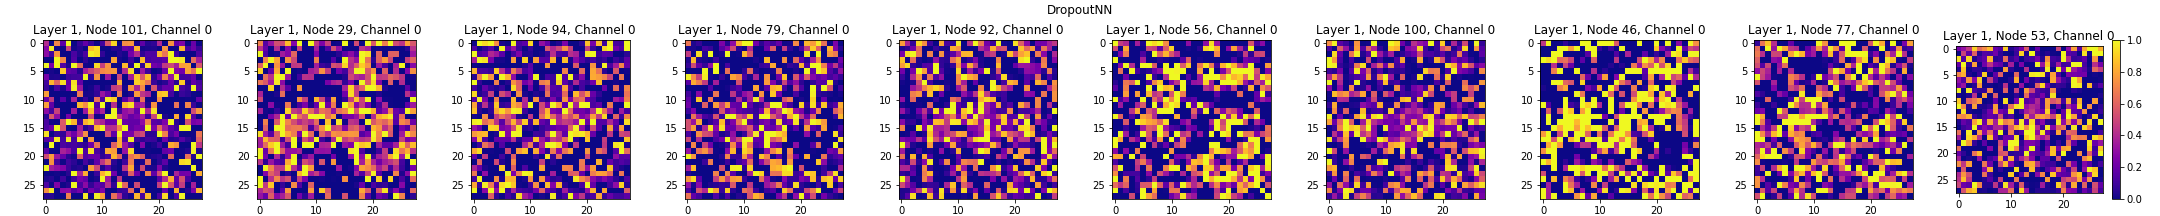

In [113]:
%matplotlib inline
dropout_res